In [351]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

import torch
from   torch.utils import data
from data.data_utils import Dataset

## Compare Sin results

### load data

In [352]:
data_path_test = 'data/sin/sin-te-data.pkl'
data_path_train = 'data/sin/sin-tr-data.pkl'
device = 'cpu'
dtype = torch.float64
batch_size = 10
shuffle = False
num_workers = 0
Ntrain = 80

In [353]:
X_te = torch.load(data_path_test)
X_te = X_te.to(device).to(dtype)
X_tr = torch.load(data_path_train)
X_tr = X_tr.to(device).to(dtype)


In [354]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers, 'drop_last': True}
trainset = Dataset(X_tr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(X_te)
testset  = data.DataLoader(testset, **params)

### load models

In [355]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

##### Node + inv + contrastive

In [356]:
T_in = 3
T_inv = 10
ode_latent_dim = 4
inv_latent_dim = 4 
order = 1 
D_in  = ode_latent_dim + inv_latent_dim
D_out = int(ode_latent_dim / order)
solver = 'euler'
use_adjoint = False
frames = 5
dt = 0.1
aug = True
Nobj = 1
task ='sin'
n_filt = 8 
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'dcgan'
last_layer_gp  = None

In [357]:
node_inv_contr = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [358]:
node_inv_contr.to(device)
fname = 'results/sin/21_01_2023-12:07/invodevae.pth'
node_inv_contr.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=4, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=8, bias=True)
        )
        (gru): GRU(1, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=100, bias=True)
        

##### Node + inv 

In [359]:
node_inv = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [360]:
node_inv.to(device)
fname = 'results/sin/21_01_2023-12:09/invodevae.pth'
node_inv.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=4, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=8, bias=True)
        )
        (gru): GRU(1, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=100, bias=True)
        

##### Node 

In [361]:
T_in = 10
inv_latent_dim=0
D_in = ode_latent_dim
D_out = int(D_in/order)
aug=False
node_base= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [362]:
node_base.to(device)
fname = 'results/sin/21_01_2023-12:10/invodevae.pth'
node_base.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_base.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=4, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=8, bias=True)
        )
        (gru): GRU(1, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=100, bias=True)
        

##### plot results

In [363]:
from model.misc.plot_utils import plot_latent_traj
def plot_C(C):
    '''
    C - embeddings L, N, T, q
    N, T, q - size of tensors
    '''
    C = C.mean(0) if C.ndim==4 else C
    N_,T_,q_ = C.shape
    C = C.reshape(N_*T_,q_) # NT,q

    diff = C.unsqueeze(0) - C.unsqueeze(1) # NT,NT,q pairwise diffs
    dist = diff.pow(2).sum(2).sqrt()

    plt.figure(1,(12,9))
    plt.imshow(dist.detach().cpu().numpy())
    plt.colorbar()

    
    C_ = C / C.pow(2).sum(1,keepdim=True).sqrt() # normalized features
    theta = (C_.unsqueeze(0) * C_.unsqueeze(1)).sum(2) # NT,NT angle between features

    plt.figure(2,(12,9))
    plt.imshow(theta.detach().cpu().numpy())
    plt.colorbar()

def plot_sin(X, Xrec, show=False, fname='predictions.png', N=None, D=None, T_in = 3, T_inv=10, T=50):
    '''
         X    - [N,T,d] 
        Xrec - [L,N,Ttest,d]
    '''
    if N is None:
        N = min(X.shape[0],6)
    if D is None:
        D = min(X.shape[-1],3)
    Xnp    = X.detach().cpu().numpy()
    Xrecnp = Xrec.detach().cpu().numpy()
    nc,nr = D, N
    fig, axes = plt.subplots(nr, nc, figsize=(nc*10,nr*2), squeeze=False, sharex=True, sharey=True)
    for n in range(N):
        for d in range(D):
            axes[n,d].plot(Xrecnp[:,n,:,d].T, '-', color='tab:gray', lw=0.7, alpha=0.5)
            axes[n,d].plot(Xnp[n,:,d].T, '-', color='tab:blue', lw=2)
            axes[n,d].axvline(x=T_in,linewidth=2, color='tab:blue', ls='-')
            if T_inv is not None:
                axes[n,d].axvline(x=T_inv,linewidth=2, color='tab:blue', ls='-.')
            axes[n,d].axvline(x=T,linewidth=2, color='tab:blue', ls=':')
            axes[n,d].set_xlim([-1, 150])
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

In [364]:
test_idx = [12,0,5,23,20,24]

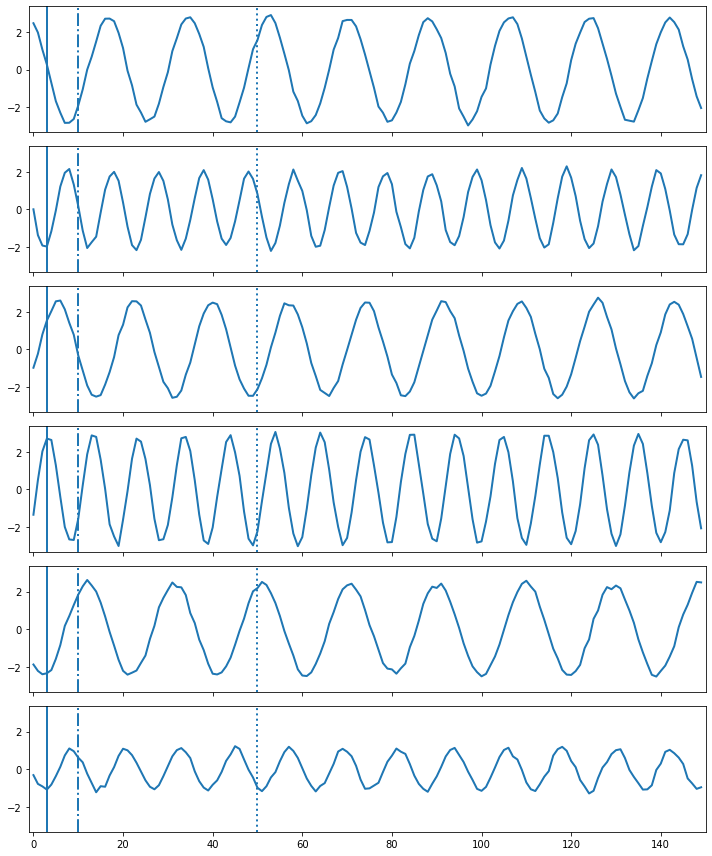

In [197]:
plot_sin(X_te[test_idx], X_te[test_idx].unsqueeze(0), show=True)

In [119]:
plotL= 16
forecast_te = 1

##### Node+ inv +cont

In [338]:
Xrec_te, ztL_te, _, _, C_full = node_inv_contr(X_te[test_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

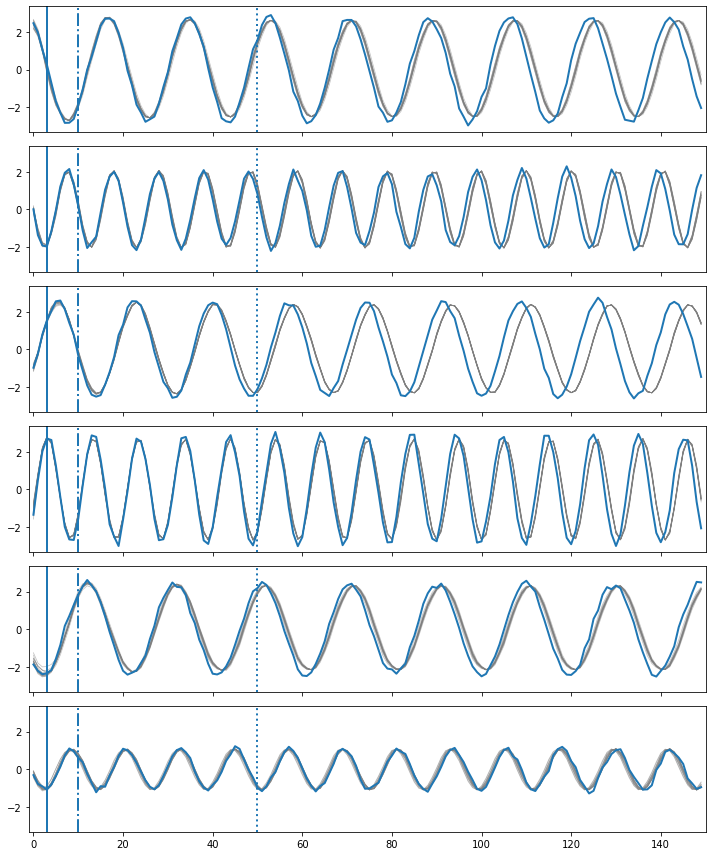

In [339]:
plot_sin(X_te[test_idx], Xrec_te, show=True, T_in=3, T_inv=10, T=50)

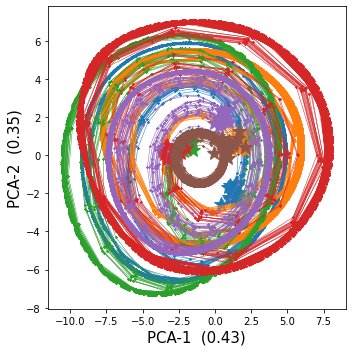

In [341]:
plot_latent_traj(ztL_te, show=True, Nplot=6)

##### Node+ inv

In [343]:
Xrec_te, ztL_te, _, _, C_inv = node_inv(X_te[test_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

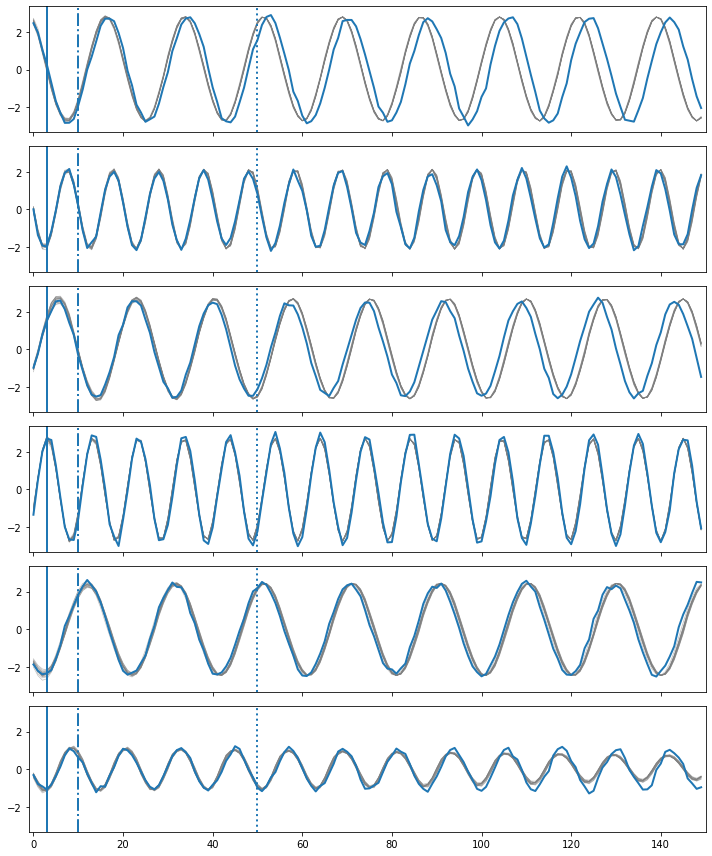

In [344]:
plot_sin(X_te[test_idx], Xrec_te, show=True, T_in=3, T_inv=10, T=50)

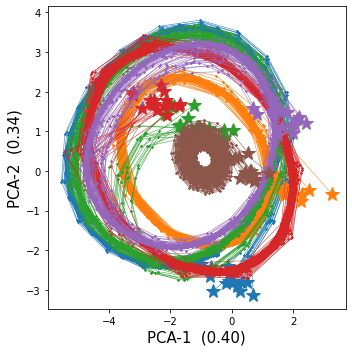

In [345]:
plot_latent_traj(ztL_te, show=True, Nplot=6)

##### Node 

In [346]:
Xrec_te, ztL_te, _, _, C_base = node_base(X_te[test_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

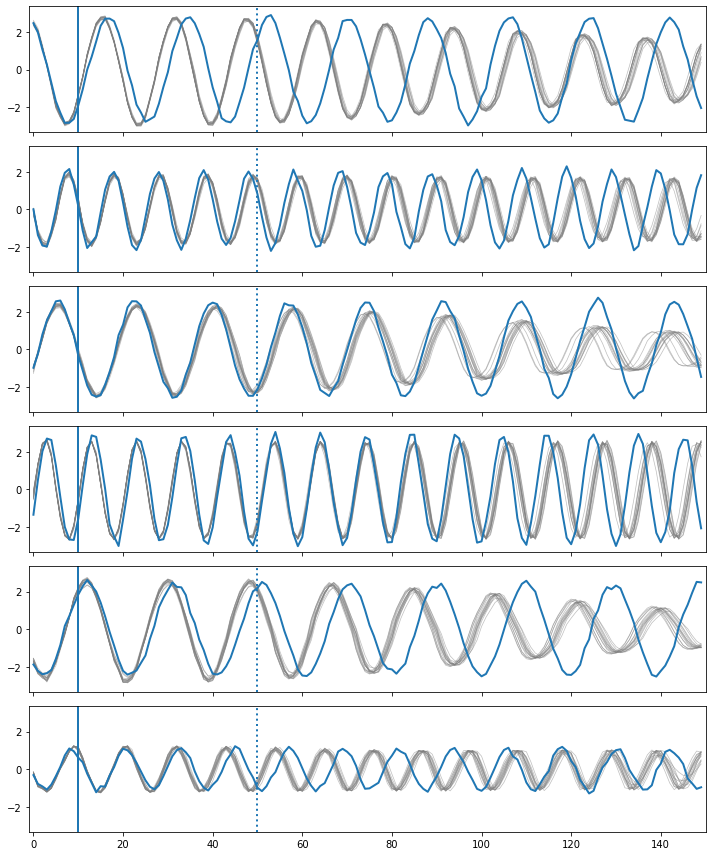

In [347]:
plot_sin(X_te[test_idx], Xrec_te, show=True, T_in=10, T_inv=None, T=50)

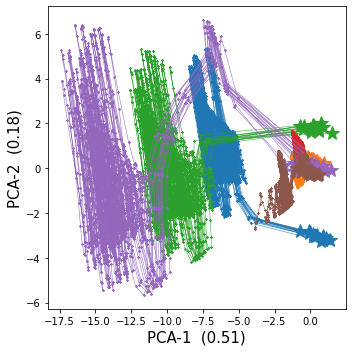

In [348]:
plot_latent_traj(ztL_te, show=True, Nplot=6)

Plot MSE (std)

In [365]:
def compute_mse(model, dataset, T_inv=10, T=50, T_forecast=150, L=16, Eps=10): 
    T_set = [T_inv, T, T_forecast]
    dict_mse = {str(T):(None,None) for T in T_set}
    for T in T_set:
        mses=[]
        for ep in range(Eps):
            for data_batch in dataset:
                data_batch = data_batch.to(model.device)
                in_data = data_batch[:,:T]
                Xrec, ztL, (s0_mu, s0_logv), (v0_mu, v0_logv), C = model(in_data, L, T_custom=T)
                mse   = torch.mean((Xrec-in_data)**2)
                mses.append(mse.item())
        
        dict_mse[str(T)] = (np.mean(np.array(mses)), np.std(np.array(mses)))
    return dict_mse

Neural-ODE + inv + contr

In [366]:
node_inv_contr_mse = compute_mse(node_inv_contr, testset)
for key,item in node_inv_contr_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.050 (0.006)
Sequence length 50 with mse 0.082 (0.037)
Sequence length 150 with mse 0.495 (0.192)


Neural-ODE + inv

In [367]:
node_inv_mse = compute_mse(node_inv, testset)
for key,item in node_inv_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.035 (0.006)
Sequence length 50 with mse 0.078 (0.025)
Sequence length 150 with mse 0.368 (0.215)


Neural-ODE

In [368]:
node_base_mse = compute_mse(node_base, testset)
for key,item in node_base_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.056 (0.010)
Sequence length 50 with mse 0.358 (0.079)
Sequence length 150 with mse 1.898 (0.359)


plot report

In [371]:
def plot_mse(model_inv_contr, model_inv, model_base):
    fig = plt.figure(figsize=(5,5))
    x = [1,2,3]

    plt.errorbar(x, [item[0] for key, item in model_inv_contr.items()], yerr=[item[1] for key, item in model_inv_contr.items()], ls='--', marker=".", color="tab:green", label='NODE+inv+cont')

    plt.errorbar(x, [item[0] for key, item in model_inv.items()], yerr=[item[1] for key, item in model_inv.items()], ls=':', marker="v", color="tab:blue", label='NODE+inv')

    plt.errorbar(x, [item[0] for key, item in model_base.items()], yerr=[item[1] for key, item in model_base.items()], ls='-.', marker="s", color="tab:orange", label='NODE')

    plt.xticks(x, [key for key, item in model_inv_contr.items()], rotation='horizontal')
    plt.legend(loc='upper left')
    plt.ylabel('MSE')
    plt.xlabel('Sequence Length')
    plt.grid()
    plt.show()
    

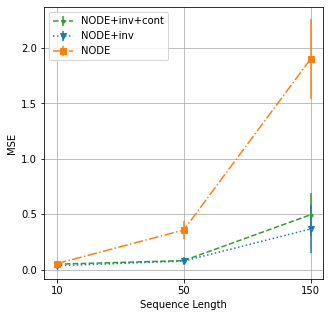

In [372]:
plot_mse(node_inv_contr_mse, node_inv_mse, node_base_mse)

Contrastive Matrix Z

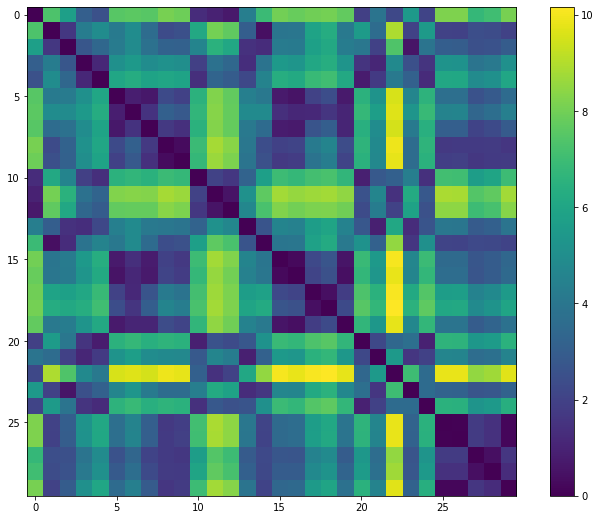

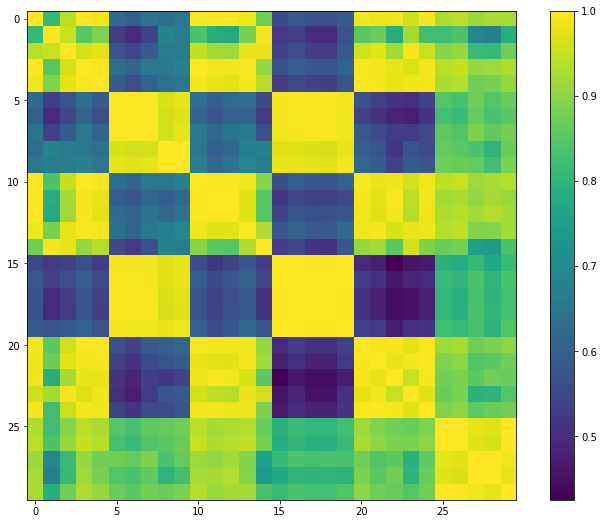

In [205]:
plot_C(C_full)

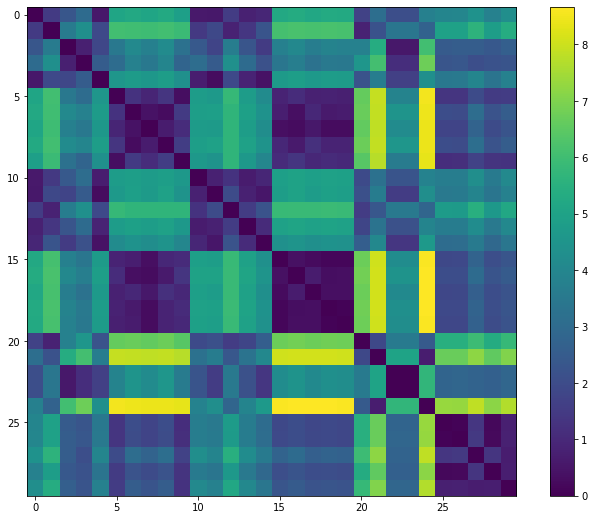

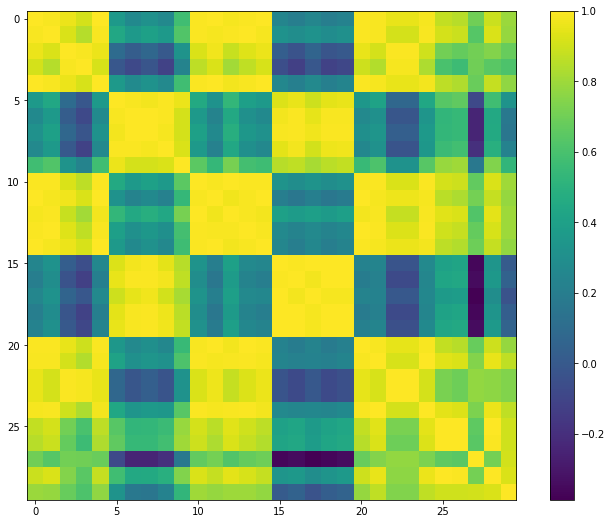

In [206]:
plot_C(C_inv)